In [14]:
from img_classify.dataset import *
from img_classify.downloader import *
from img_classify.evaluate_model import *
from img_classify.tools import *
from keras import Sequential
from keras.applications import *
from keras.callbacks import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import AdamW
from keras.src.preprocessing.image import ImageDataGenerator
from keras.src.utils import set_random_seed

In [15]:
# Tải dữ liệu từ thư viện Kaggle
if not os.path.exists('datasets/corn_leaf_disease'):
	kaggle_downloader(
		'corn_leaf_disease',
		'smaranjitghose/corn-or-maize-leaf-disease-dataset'
	)

In [16]:
# Thiết lập chung
train_path = 'datasets/corn_leaf_disease/data/'
img_save_path = 'imgs/corn_leaf_disease/'
set_random_seed(69)
IMG_SIZE = (128, 128, 3)


In [17]:
# Tạo nhãn cho tập dữ liệu
class_names = create_label_from_dir(train_path)

In [18]:
# Kiểm tra ảnh trong thư mục
check_dir(train_path)

=> Have 4 subdirectories & 0 files in datasets/corn_leaf_disease/data/
=> Have 0 subdirectories & 1307 files in datasets/corn_leaf_disease/data/Blight
=> Have 0 subdirectories & 1306 files in datasets/corn_leaf_disease/data/Common_Rust
=> Have 0 subdirectories & 1307 files in datasets/corn_leaf_disease/data/Gray_Leaf_Spot
=> Have 0 subdirectories & 1307 files in datasets/corn_leaf_disease/data/Healthy


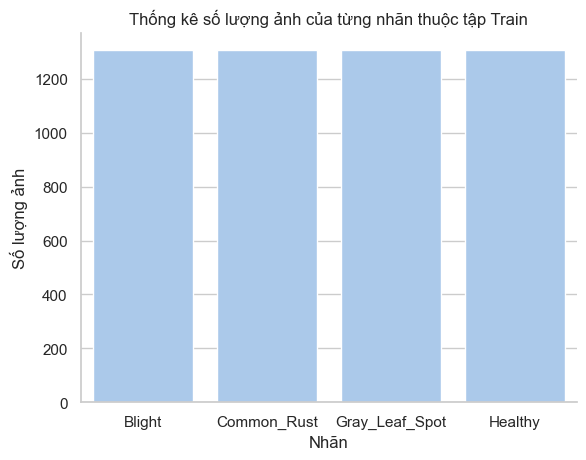

== MỨC CHÊNH LỆCH GIỮA CÁC NHÃN TẬP TRAIN SO VỚI NHÃN CAO NHẤT ==
Nhãn Blight: 100.0
Nhãn Common_Rust: 99.923
Nhãn Gray_Leaf_Spot: 100.0
Nhãn Healthy: 100.0


In [19]:
# Kiểm tra độ cân bằng dữ liệu
check_balance(
	train_path,
	class_names,
	img_save_path=os.path.join(img_save_path, 'check_balance.jpg')
)

In [20]:
# Tái cân bằng tập dữ liệu
img_model = ImageDataGenerator(
	horizontal_flip=True,
	zoom_range=.2,
	width_shift_range=.1
)

Loại trừ nhãn Blight do đã cân bằng !
Loại trừ nhãn Common_Rust do đã cân bằng !
Loại trừ nhãn Gray_Leaf_Spot do đã cân bằng !
Loại trừ nhãn Healthy do đã cân bằng !


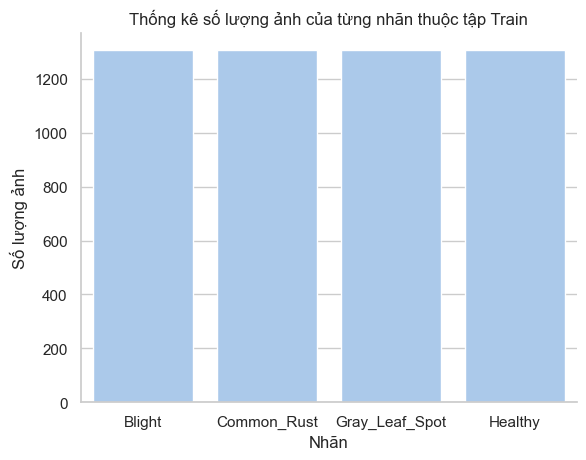

== MỨC CHÊNH LỆCH GIỮA CÁC NHÃN TẬP TRAIN SO VỚI NHÃN CAO NHẤT ==
Nhãn Blight: 100.0
Nhãn Common_Rust: 99.923
Nhãn Gray_Leaf_Spot: 100.0
Nhãn Healthy: 100.0


In [21]:
fix_imbalance_with_image_augmentation(
	train_path,
	img_size=(IMG_SIZE[0], IMG_SIZE[1]),
	img_model=img_model,
	class_names=class_names
)


# Training Model

In [22]:

## Nạp ảnh
images, labels = images_to_array(train_path, class_names, (IMG_SIZE[0], IMG_SIZE[1]))

## Tách mảng để Train/Test/Val (70/25/5)
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = train_test_val_split(
	images,
	labels,
	train_size=.75,
	test_size=.20,
	val_size=.05
)

## Tăng cường ảnh tập Train
train_img_model = ImageDataGenerator(
	brightness_range=(.3, .7),
	shear_range=.2
)
train_img_model.flow(
	train_images,
	train_labels,
	seed=69
)

## Rescale ảnh
train_images = train_images / 255.
test_images = test_images / 255.
val_images = val_images / 255.


== Thống kê số lượng ảnh sau khi tách ==
Train: 3724 ảnh
Test: 1046 ảnh
Val: 196 ảnh


In [23]:
# Xây dựng mô hình
def my_model():
	#  Thiết lập mô hình
	base_model = DenseNet121(include_top=False, input_shape=IMG_SIZE)
	base_model.trainable = False
	model = Sequential(
		[
			base_model,

			GlobalAveragePooling2D(),
			Flatten(),
			Dense(64, activation='relu', kernel_regularizer='l2'),
			Dropout(.2),
			Dense(32, activation='relu'),
			Dropout(.2),
			Dense(len(class_names), activation='softmax')
		]
	)
	# Biên dịch mô hình
	model.compile(
		AdamW(),
		CategoricalCrossentropy(),
		['accuracy']
	)
	return model

# Chọn mô hình
model = my_model()
# Khái quát mô hình
model.summary()
# Đào tạo mô hình
history = model.fit(
	train_images,
	train_labels,
	epochs=50,
	validation_data=(test_images, test_labels),
	callbacks=[
		EarlyStopping(
			monitor='val_accuracy',
			patience=3,
			restore_best_weights=True
		),
		ReduceLROnPlateau(
			monitor='val_accuracy',
			factor=.1,
			patience=1,
			min_lr=.0001
		),
		ModelCheckpoint(
			'models/checkpoints/corn_leaf_disease/',
			monitor='val_accuracy',
			save_best_only=True
		)
	]
)
# Lưu mô hình
model.save('models/corn_leaf_disease_model.keras')
## => Result: Accuracy ~ 91%

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                20

INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 204s 2s/step - loss: 1.2833 - accuracy: 0.7237 - val_loss: 0.7662 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.8499INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 176s 2s/step - loss: 0.7048 - accuracy: 0.8499 - val_loss: 0.6201 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 3/50
117/117 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.8808INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 173s 1s/step - loss: 0.5412 - accuracy: 0.8808 - val_loss: 0.5100 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 4/50
117/117 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8907INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 179s 2s/step - loss: 0.4527 - accuracy: 0.8907 - val_loss: 0.4308 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 5/50
117/117 [==============================] - 159s 1s/step - loss: 0.3979 - accuracy: 0.9052 - val_loss: 0.4485 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 6/50
117/117 [==============================] - ETA: 0s - loss: 0.3347 - accuracy: 0.9270INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 198s 2s/step - loss: 0.3347 - accuracy: 0.9270 - val_loss: 0.3888 - val_accuracy: 0.9025 - lr: 1.0000e-04
Epoch 7/50
117/117 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.9310INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 205s 2s/step - loss: 0.3213 - accuracy: 0.9310 - val_loss: 0.3794 - val_accuracy: 0.9044 - lr: 1.0000e-04
Epoch 8/50
117/117 [==============================] - 176s 2s/step - loss: 0.3094 - accuracy: 0.9390 - val_loss: 0.3745 - val_accuracy: 0.9044 - lr: 1.0000e-04
Epoch 9/50
117/117 [==============================] - ETA: 0s - loss: 0.3000 - accuracy: 0.9401INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 198s 2s/step - loss: 0.3000 - accuracy: 0.9401 - val_loss: 0.3670 - val_accuracy: 0.9054 - lr: 1.0000e-04
Epoch 10/50
117/117 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.9393INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 204s 2s/step - loss: 0.2978 - accuracy: 0.9393 - val_loss: 0.3670 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 11/50
117/117 [==============================] - 202s 2s/step - loss: 0.2927 - accuracy: 0.9377 - val_loss: 0.3596 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 12/50
117/117 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.9444INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


INFO:tensorflow:Assets written to: models/checkpoints/corn_leaf_disease\assets


117/117 [==============================] - 208s 2s/step - loss: 0.2831 - accuracy: 0.9444 - val_loss: 0.3563 - val_accuracy: 0.9140 - lr: 1.0000e-04
Epoch 13/50
117/117 [==============================] - 157s 1s/step - loss: 0.2785 - accuracy: 0.9396 - val_loss: 0.3493 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 14/50
117/117 [==============================] - 144s 1s/step - loss: 0.2680 - accuracy: 0.9439 - val_loss: 0.3486 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 15/50
117/117 [==============================] - 146s 1s/step - loss: 0.2660 - accuracy: 0.9433 - val_loss: 0.3428 - val_accuracy: 0.9101 - lr: 1.0000e-04


# Evaluate Model

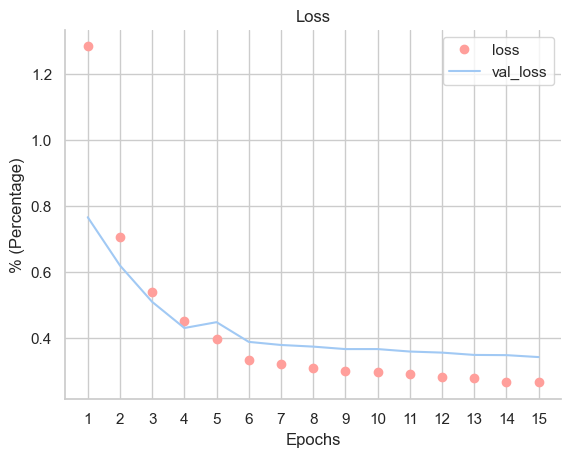

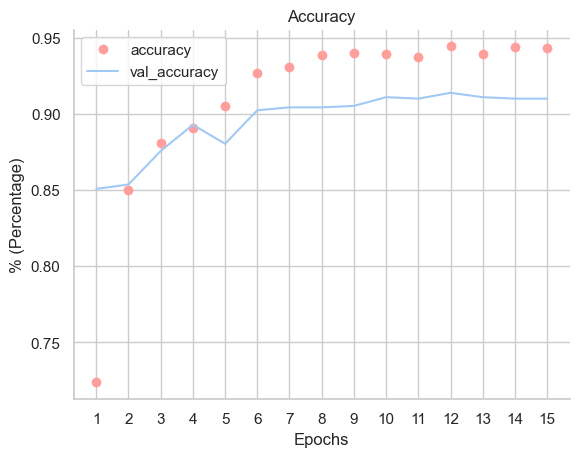

33/33 [==============================] - 32s 974ms/step - loss: 0.3563 - accuracy: 0.9140
Sai số: 0.35630545020103455
Độ chính xác: 0.913957953453064
7/7 [==============================] - 8s 837ms/step


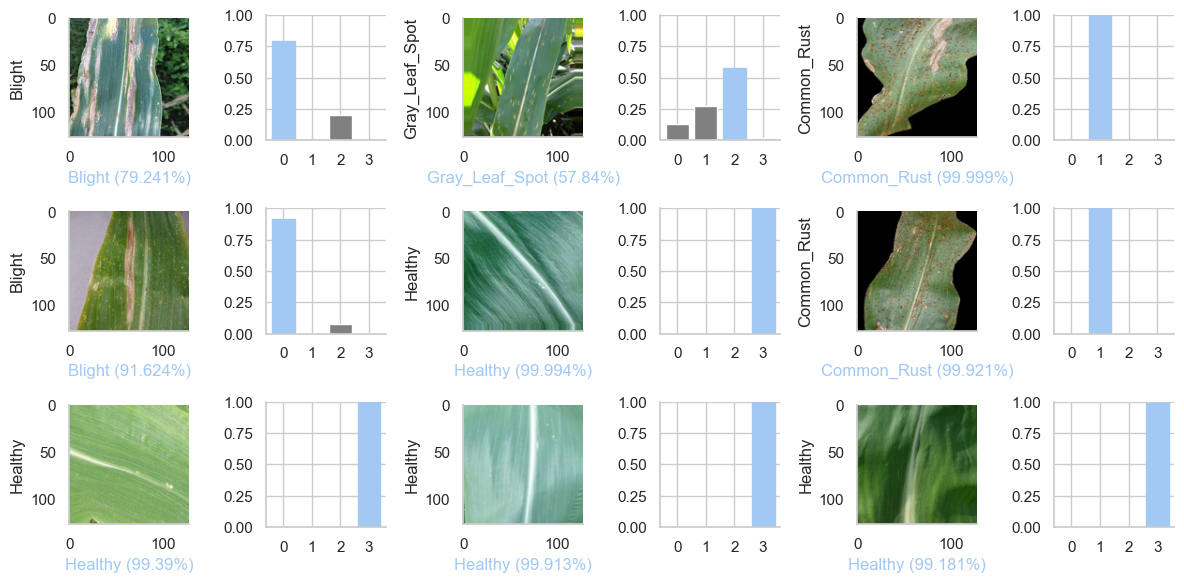

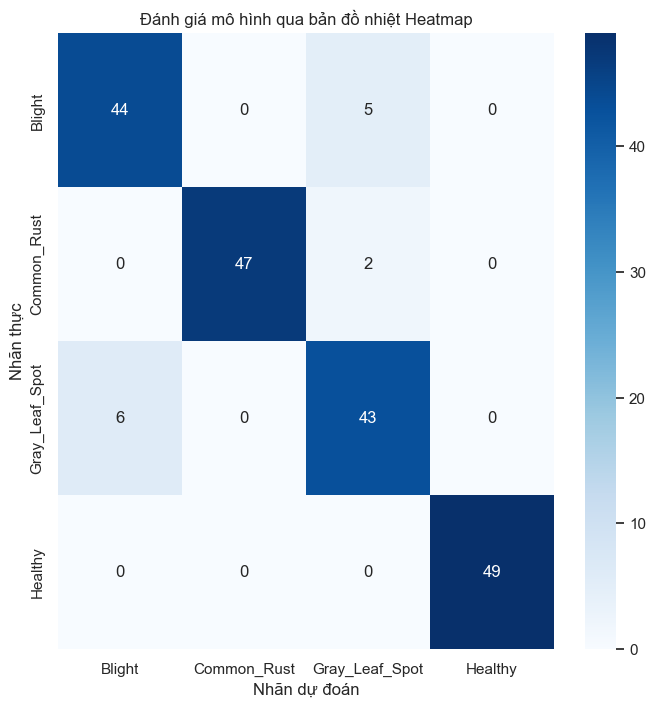

In [24]:
# Đánh giá quá trình đào tạo
EvalofTraining(history, img_save_path)
# Đánh giá mô hình qua tập Test
sai_so, do_chinh_xac = model.evaluate(test_images, test_labels)
print(f'Sai số: {sai_so}')
print(f'Độ chính xác: {do_chinh_xac}')
# Dự đoán để đánh giá mô hình
pred_labels = model.predict(val_images)
eval_of_model_with_images(
	3, 3, val_images, pred_labels, val_labels, class_names,
	img_save_path=os.path.join(img_save_path, 'eval_of_model_with_images.jpg')
)
heatmap_plot(
	val_labels, pred_labels, class_names,
	img_save_path=os.path.join(img_save_path, 'eval_of_model_with_heatmap.jpg')
)
